In [2]:
import numpy as np  # Para operaciones numéricas y manipulación de arrays
import pandas as pd  # Para manipulación de datos y creación de DataFrames
import matplotlib.pyplot as plt  # Para visualización de gráficos
from astropy.io import fits  # Para leer archivos FITS
from sklearn.model_selection import train_test_split  # Para dividir datos en conjuntos de entrenamiento y validación
import tensorflow as tf  # Para trabajar con TensorFlow
from tensorflow.keras.models import load_model  # Para cargar modelos Keras previamente guardados
import tensorflow_addons as tfa  # Para trabajar con capas adicionales de TensorFlow
from tensorflow.keras.utils import CustomObjectScope  # Para cargar modelos Keras con objetos personalizados


2023-04-24 16:54:53.986499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 16:54:54.326675: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-24 16:54:55.653823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-24 16:54:55.653891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot

## Catálogo de Marcos

In [3]:
path_datos = "../data/"
path = path_datos + "ZW2.msw_image.fits"
hdul = fits.open(path)

# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor_marcos.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

In [4]:
all_data = hdul[0].data

# Cargar los índices desde el archivo de texto
def load_indices_from_txt(filename="indices.txt"):
    indices = np.loadtxt(filename, dtype=int)
    return indices

indices_from_file = load_indices_from_txt("indices.txt")

# Obtener los índices que no están en el archivo
all_indices = set(range(all_data.shape[0]))
indices_not_in_file = sorted(list(all_indices.difference(indices_from_file)))

# Seleccionar datos utilizando los índices que no están en el archivo
#data = all_data[indices_not_in_file]

# Seleccionar todos los datos para la evaluación
data = all_data

# Seleccionamos 10 imagenes solo para que pueda compilar
# data = data[:10]

# Reformatear y normalizar las imágenes
input_data = np.array(data)
input_data = input_data.reshape((data.shape[0], data.shape[1], data.shape[2], 1))
input_data = input_data.astype("float32") / 255.0

# Crear un array de salida repetido x veces (uno para cada imagen de entrada)
output_data = np.repeat(label[np.newaxis, :, :], data.shape[0], axis=0)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

with tf.keras.utils.CustomObjectScope({'InstanceNormalization': tfa.layers.InstanceNormalization}):
    model = load_model("cnn1.h5", compile=False)


2023-04-24 16:55:42.107453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 16:55:42.134269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-24 16:55:42.134284: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-24 16:55:42.138609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

In [6]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # Ajusta los parámetros del optimizador según sea necesario
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Iteración 1: Evaluando imágenes 0-9
1/1 [==============================] - 4s 4s/step
Iteración 2: Evaluando imágenes 10-19
1/1 [==============================] - 3s 3s/step
Iteración 3: Evaluando imágenes 20-29
1/1 [==============================] - 3s 3s/step
Iteración 4: Evaluando imágenes 30-39
1/1 [==============================] - 3s 3s/step
Iteración 5: Evaluando imágenes 40-49
1/1 [==============================] - 3s 3s/step
Iteración 6: Evaluando imágenes 50-59
1/1 [==============================] - 3s 3s/step
Iteración 7: Evaluando imágenes 60-69
1/1 [==============================] - 3s 3s/step
Iteración 8: Evaluando imágenes 70-79
1/1 [==============================] - 3s 3s/step
Iteración 9: Evaluando imágenes 80-89
1/1 [==============================] - 3s 3s/step
Iteración 10: Evaluando imágenes 90-99
1/1 [==============================] - 3s 3s/step
Iteración 11: Evaluando imágenes 100-109
1/1 [==============================] - 3s 3s/step
Iteración 12: Evaluando imágen

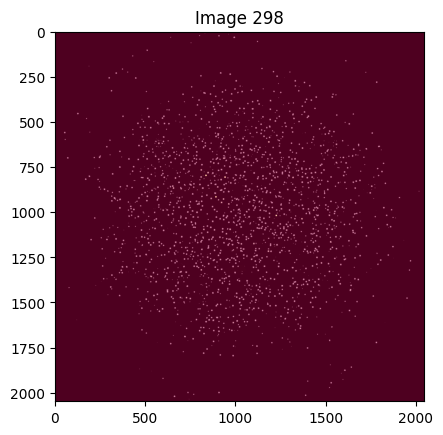

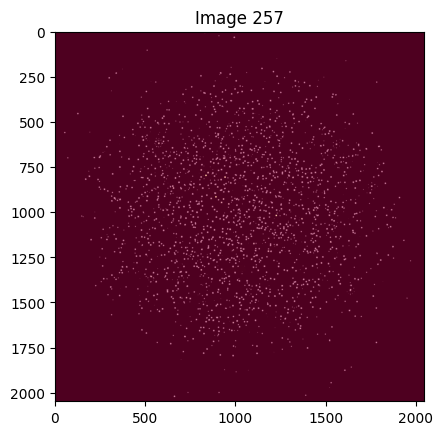

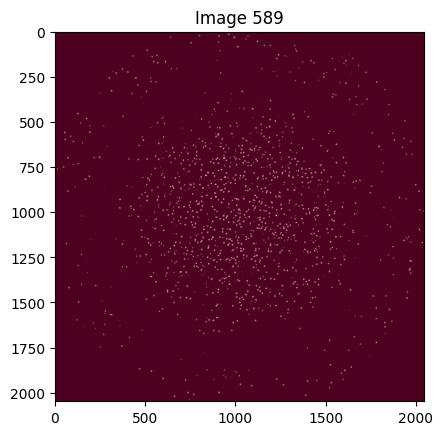

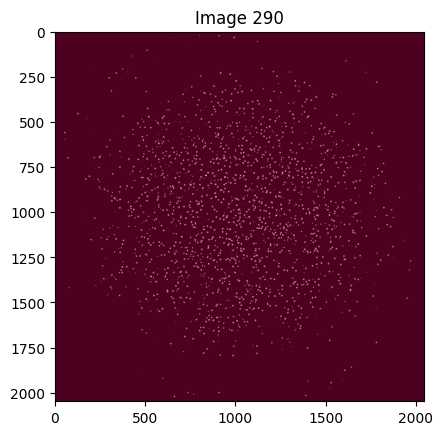

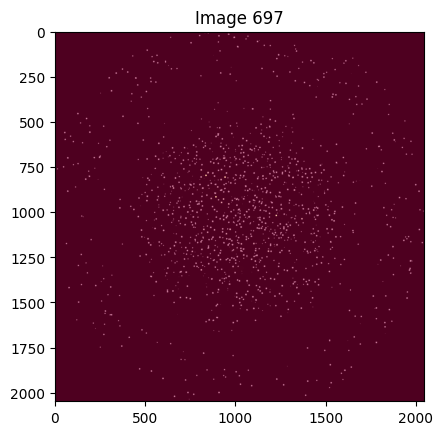

In [7]:
# Predecir con el modelo en grupos de 10 imágenes para evitar problemas de memoria
batch_size = 10
num_batches = int(np.ceil(len(input_data) / batch_size))
predictions = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(input_data))
    print(f"Iteración {i + 1}: Evaluando imágenes {start_idx}-{end_idx - 1}")
    batch_predictions = model.predict(input_data[start_idx:end_idx])
    batch_predictions = np.round(batch_predictions).astype(int)
    predictions.extend(batch_predictions)

predictions = np.array(predictions)

# Graficar los resultados de 5 imágenes al azar
num_images_to_show = 5
for i in range(num_images_to_show):
    i= np.random.randint(0, len(input_data))
    plt.figure()
    plt.imshow(predictions[i], cmap="gray")  # Predicción
    plt.imshow(input_data[i], cmap="Spectral", alpha=0.5)  # Imagen
    plt.title(f"Image {i}")
    plt.show()



In [8]:
# # Predecir con el modelo
# predictions = model.predict(input_data)
# predictions = np.round(predictions).astype(int)  # Redondear las predicciones a 0 o 1 (aqui se puede cambiar el umbral)

# # Graficar los resultados de 5 imágenes
# num_images_to_show = 5
# for i in range(num_images_to_show):
#     plt.figure()
#     plt.imshow(predictions[i], cmap="gray")  # Predicción
#     plt.imshow(input_data[i], cmap="Spectral", alpha=0.5)  # Imagen
#     plt.show()

In [9]:
# Función para obtener las coordenadas de las fuentes
def get_source_coordinates(lines):
    coords = []
    for idx, line in enumerate(lines):
        x, y, _ = line.split()
        x, y = int(float(x)), int(float(y))
        coords.append((idx, x, y))
    return coords

# Obtener las coordenadas de las fuentes y sus números
source_coordinates = get_source_coordinates(lines)

# Función para obtener la probabilidad promedio de una región de 8x8 alrededor de una coordenada
def get_region_probability(prediction, x, y):
    region = prediction[max(0, y-4):min(prediction.shape[0], y+4), max(0, x-4):min(prediction.shape[1], x+4)]
    
    if region.size == 0:  # Comprobar si la región está vacía
        return 0
    
    return region.mean()


In [10]:
results = []

# Iterar sobre todos los elementos (imágenes)
for idx in range(len(predictions)):
    prediction = predictions[idx]
    data = []
    for source_idx, x, y in source_coordinates:
        probability = get_region_probability(prediction, x, y)
        data.append([source_idx, x, y, probability])

    # Crear un DataFrame con los resultados y guardarlo en la lista 'results'
    df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{idx}"])
    results.append(df)

# Combinar todos los DataFrames en uno solo usando un merge iterativo
final_df_m = results[0]

for i in range(1, len(results)):
    final_df_m = final_df_m.merge(results[i], on=["source_number", "x", "y"], how="outer")


In [11]:
# results = []

# # Iterar sobre los primeros 10 elementos de indices_not_in_file
# for local_idx, global_idx in enumerate(indices_not_in_file[:10]):
#     prediction = predictions[local_idx]
#     data = []
#     for source_idx, x, y in source_coordinates:
#         probability = get_region_probability(prediction, x, y)
#         data.append([source_idx, x, y, probability])

#     # Crear un DataFrame con los resultados y guardarlo en la lista 'results'
#     df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{global_idx}"])
#     results.append(df)

# # Combinar todos los DataFrames en uno solo usando un merge iterativo
# final_df_m = results[0]

# for i in range(1, len(results)):
#     final_df_m = final_df_m.merge(results[i], on=["source_number", "x", "y"], how="outer")


In [12]:
final_df_m


,source_number,x,y,probability_image_0,probability_image_1,probability_image_2,probability_image_3,probability_image_4,probability_image_5,probability_image_6,...,probability_image_891,probability_image_892,probability_image_893,probability_image_894,probability_image_895,probability_image_896,probability_image_897,probability_image_898,probability_image_899,probability_image_900
0,0,830,7,0.875000,0.875000,0.875000,0.875000,0.875000,0.859375,0.859375,...,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625
1,1,908,27,0.890625,0.875000,0.875000,0.875000,0.875000,0.906250,0.921875,...,0.781250,0.781250,0.781250,0.796875,0.796875,0.796875,0.796875,0.796875,0.812500,0.812500
2,2,992,35,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,...,0.968750,0.968750,0.968750,0.968750,0.968750,0.968750,0.968750,0.968750,0.968750,0.968750
3,3,1121,58,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,...,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500
4,4,904,61,0.718750,0.718750,0.703125,0.703125,0.703125,0.703125,0.703125,...,0.328125,0.328125,0.328125,0.328125,0.328125,0.328125,0.328125,0.328125,0.328125,0.328125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,1701,1079,1068,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,...,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875
1702,1702,694,1066,0.921875,0.921875,0.921875,0.921875,0.921875,0.921875,0.921875,...,0.578125,0.562500,0.562500,0.562500,0.578125,0.578125,0.578125,0.578125,0.578125,0.562500
1703,1703,1291,1059,0.453125,0.453125,0.437500,0.437500,0.437500,0.468750,0.468750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1704,1704,1356,1037,0.078125,0.078125,0.078125,0.078125,0.078125,0.078125,0.078125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
print(final_df_m) 

      source_number     x     y  probability_image_0  probability_image_1  \
0                 0   830     7             0.875000             0.875000   
1                 1   908    27             0.890625             0.875000   
2                 2   992    35             0.984375             0.984375   
3                 3  1121    58             0.984375             0.984375   
4                 4   904    61             0.718750             0.718750   
...             ...   ...   ...                  ...                  ...   
1701           1701  1079  1068             0.640625             0.640625   
1702           1702   694  1066             0.921875             0.921875   
1703           1703  1291  1059             0.453125             0.453125   
1704           1704  1356  1037             0.078125             0.078125   
1705           1705   696  1034             0.812500             0.812500   

      probability_image_2  probability_image_3  probability_image_4  \
0   

In [13]:
np.shape(final_df_m)

(1706, 904)

In [14]:
final_df_m.to_csv("resultados_catalogo_marcos.csv", index=False)


In [34]:
final_df_m_transposed = final_df_m.T
final_df_m_transposed = final_df_m_transposed.iloc[3:]
final_df_m_transposed

,0,1,2,3,4,5,6,7,8,9,...,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705
probability_image_0,0.875000,0.890625,0.984375,0.984375,0.718750,0.921875,0.968750,0.875000,0.875000,0.937500,...,0.796875,0.609375,0.984375,0.875000,0.843750,0.640625,0.921875,0.453125,0.078125,0.812500
probability_image_1,0.875000,0.875000,0.984375,0.984375,0.718750,0.921875,0.968750,0.875000,0.859375,0.937500,...,0.796875,0.593750,0.984375,0.875000,0.843750,0.640625,0.921875,0.453125,0.078125,0.812500
probability_image_2,0.875000,0.875000,0.984375,0.984375,0.703125,0.937500,0.968750,0.890625,0.875000,0.921875,...,0.796875,0.593750,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.812500
probability_image_3,0.875000,0.875000,0.984375,0.984375,0.703125,0.921875,0.968750,0.906250,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.812500
probability_image_4,0.875000,0.875000,0.984375,0.984375,0.703125,0.921875,0.968750,0.906250,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.796875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
probability_image_896,0.640625,0.796875,0.968750,0.937500,0.328125,0.671875,0.921875,0.531250,0.500000,0.625000,...,0.687500,0.562500,0.984375,0.859375,0.390625,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_897,0.640625,0.796875,0.968750,0.937500,0.328125,0.656250,0.921875,0.531250,0.468750,0.625000,...,0.687500,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_898,0.640625,0.796875,0.968750,0.937500,0.328125,0.656250,0.921875,0.562500,0.453125,0.609375,...,0.687500,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_899,0.640625,0.812500,0.968750,0.937500,0.328125,0.656250,0.921875,0.578125,0.453125,0.609375,...,0.703125,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.500000


para una misma fuente cómo varía la probabilidad  a lo largo de las imagenes
para una muestra de fuentes

para una imagen sacar las probabilidades de todas las fuentes
repetir con una meustra de imagenes

elegir fuentes concretas viendo la imagen

In [75]:
# Calcular los percentiles para los promedios de probabilidad
q25, q75 = final_df_m_transposed.mean(axis=0).quantile([0.25, 0.75])
q25_high = final_df_m_transposed.mean(axis=0).quantile(0.25)
q75_low = final_df_m_transposed.mean(axis=0).quantile(0.75)

# Filtrar las fuentes correspondientes
fuentes_normal = final_df_m_transposed.columns[(final_df_m_transposed.mean(axis=0) >= q25) & (final_df_m_transposed.mean(axis=0) <= q75)]
fuentes_altas = final_df_m_transposed.columns[final_df_m_transposed.mean(axis=0) > q75]
fuentes_bajas = final_df_m_transposed.columns[final_df_m_transposed.mean(axis=0) < q25_high]


In [81]:
print(fuentes_altas)
print(fuentes_normal)
print(fuentes_bajas)

Int64Index([   2,   47,  145,  192,  194,  213,  224,  227,  243,  249,
            ...
            1668, 1674, 1681, 1682, 1684, 1685, 1688, 1692, 1698, 1699],
           dtype='int64', length=427)
Int64Index([   0,    1,    3,    5,    6,    7,    8,    9,   10,   11,
            ...
            1687, 1689, 1693, 1695, 1696, 1697, 1700, 1701, 1702, 1705],
           dtype='int64', length=852)
Int64Index([   4,   12,   13,   22,   23,   24,   26,   33,   35,   37,
            ...
            1653, 1657, 1664, 1669, 1677, 1690, 1691, 1694, 1703, 1704],
           dtype='int64', length=427)


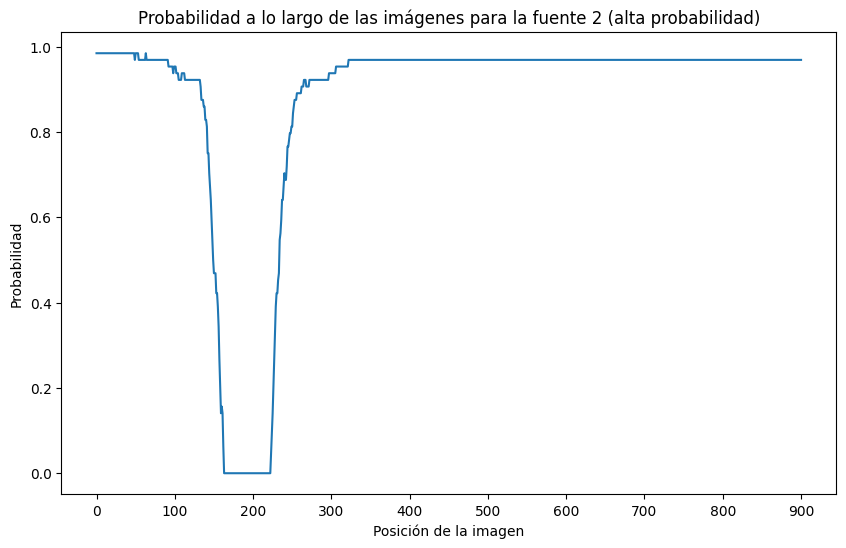

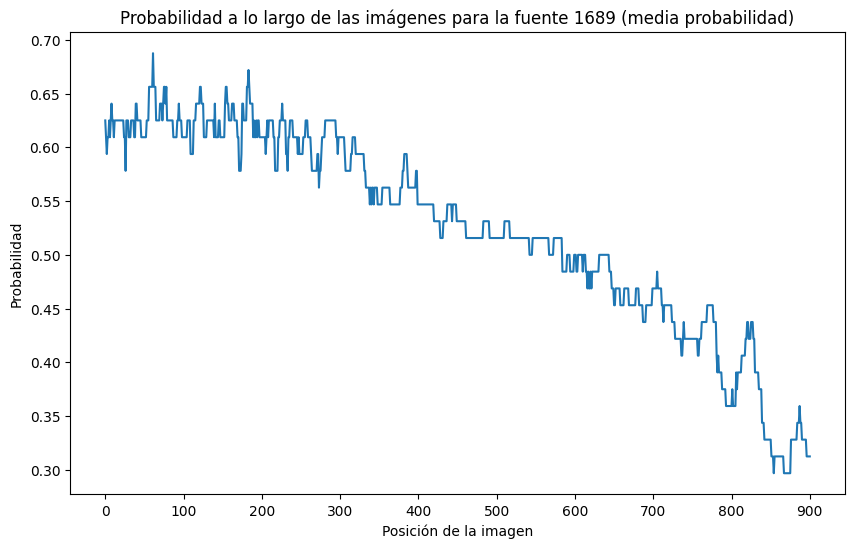

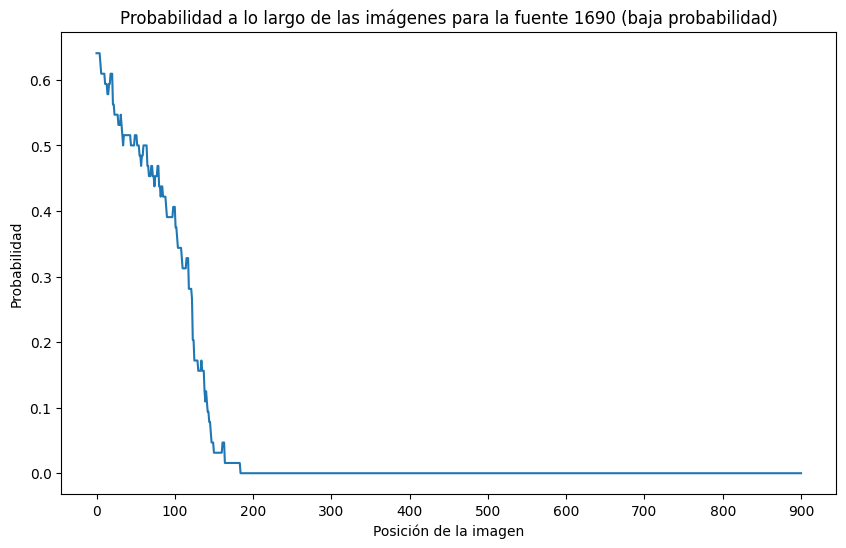

In [95]:
alta = 2
media = 1689
baja = 1690

# Gráficos para las fuentes seleccionadas
for fuente in [alta, media, baja]:
    indices = final_df_m_transposed.index[::100]
    etiquetas = indices.str.replace("probability_image_", "")
    plt.figure(figsize=(10, 6))
    plt.plot(final_df_m_transposed.loc[:, fuente])
    plt.xlabel("Posición de la imagen")
    plt.ylabel("Probabilidad")
    
    # Imprimir la clasificación de la fuente
    if fuente == alta:
        clasificacion = "alta"
    elif fuente == media:
        clasificacion = "media"
    else:
        clasificacion = "baja"
    plt.title(f"Probabilidad a lo largo de las imágenes para la fuente {fuente} ({clasificacion} probabilidad)")
    
    plt.xticks(indices, etiquetas)
    plt.show()



In [83]:
# Seleccionar las filas correspondientes a las fuentes 2, 987 y 1703
fuentes = [2, 987, 1703]
df_fuentes = df.loc[df['source_number'].isin(fuentes)]

# Seleccionar las columnas correspondientes a las posiciones XY
df_posiciones = df_fuentes[['x', 'y']]

# Mostrar las posiciones XY de las fuentes
print(df_posiciones)


         x    y
2      848   10
987    528  504
1703  1522  693


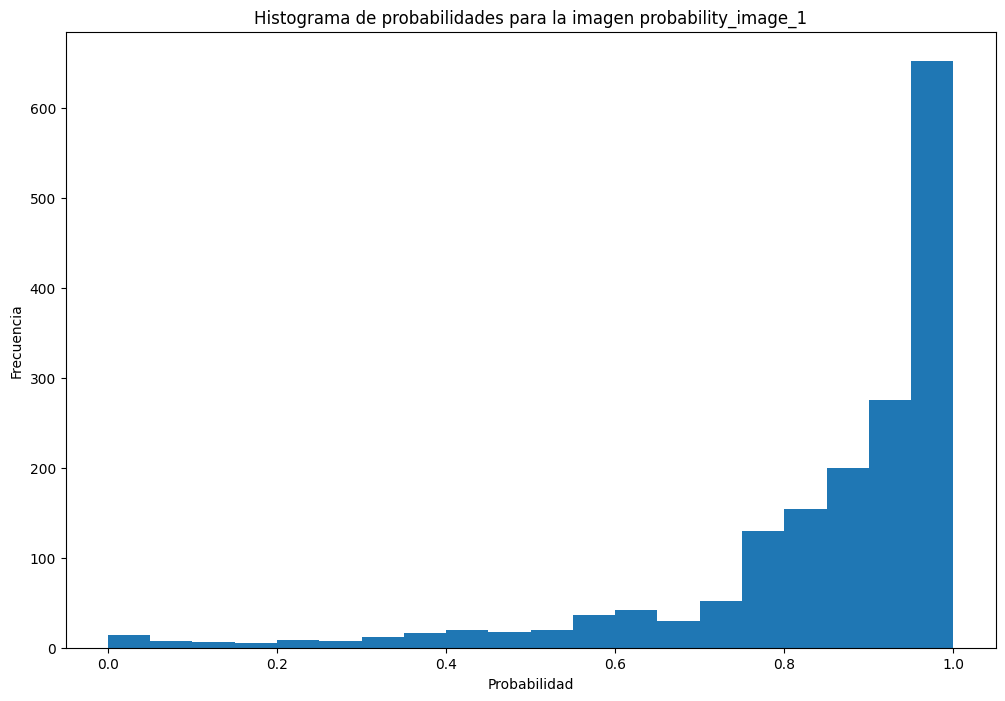

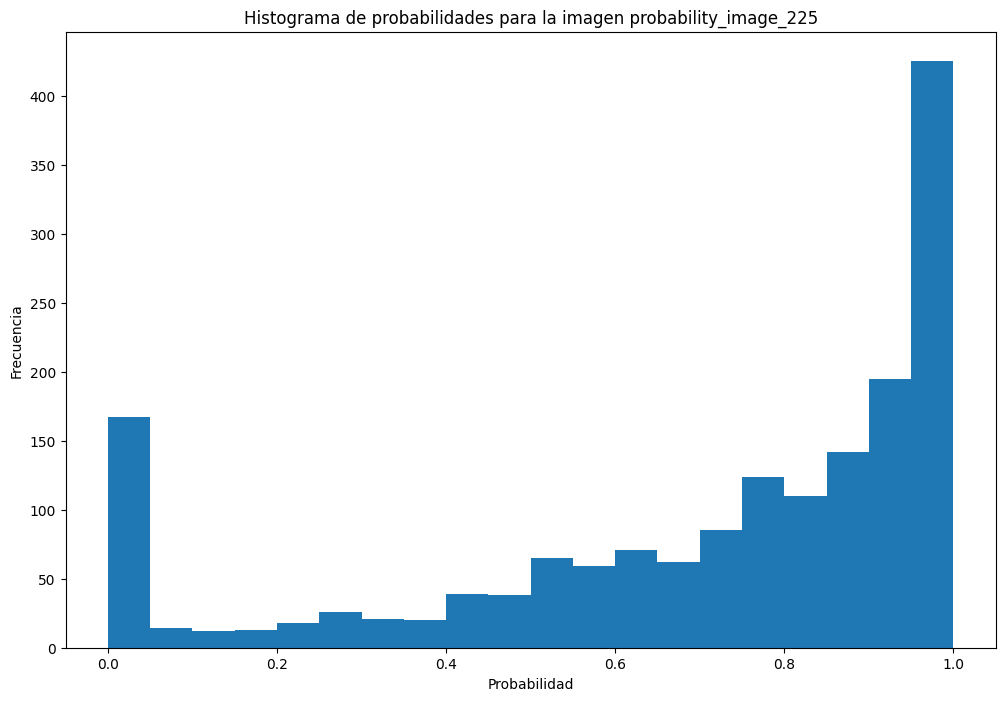

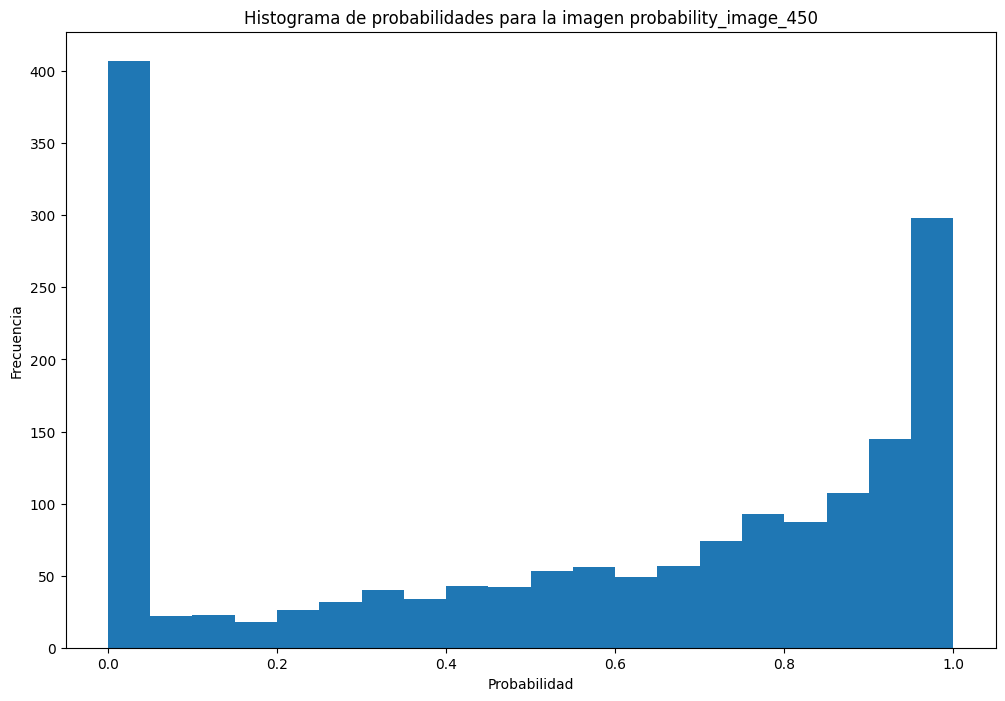

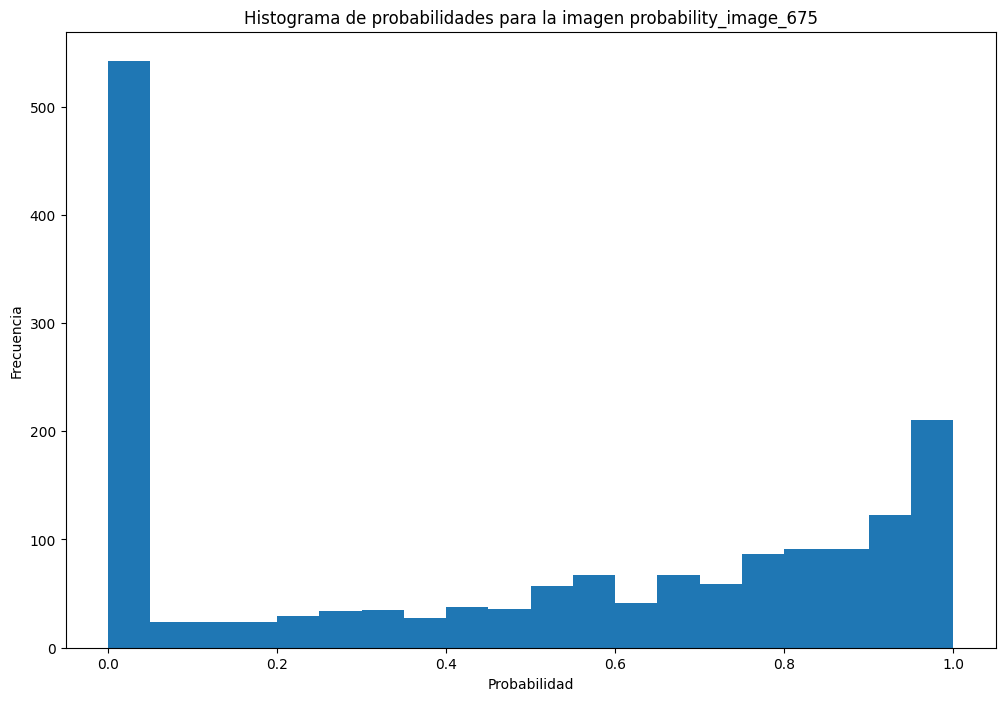

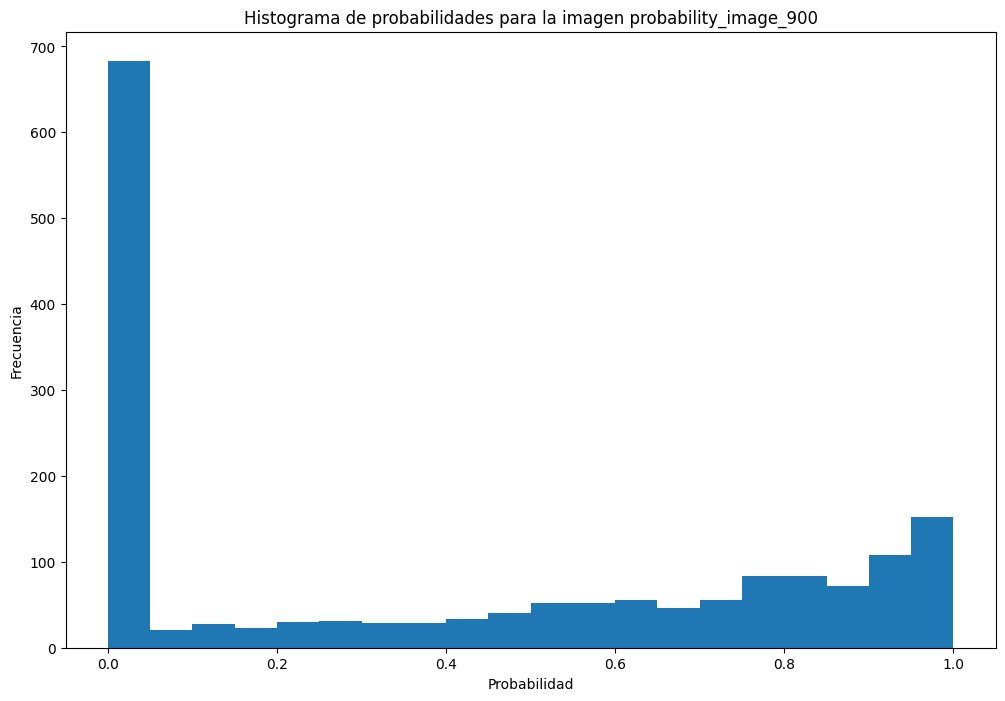

In [70]:
import numpy as np

# Seleccionar los percentiles de interés
percentiles = [0, 25, 50, 75, 100]
indices = np.percentile(range(900), percentiles)

# Convertir los índices a enteros y seleccionar las imágenes correspondientes
indices = [int(i) for i in indices]
imagenes = ["probability_image_" + str(i+1) for i in indices]

# Crear un histograma para cada imagen
for imagen in imagenes:
    # Seleccionar las probabilidades para la imagen de interés
    probs = final_df_m_transposed.loc[imagen, :]

    # Crear un histograma
    plt.figure(figsize=(12, 8))
    plt.hist(probs, bins=20)
    plt.xlabel("Probabilidad")
    plt.ylabel("Frecuencia")
    plt.title(f"Histograma de probabilidades para la imagen {imagen}")
    plt.show()



In [16]:
final_df_m_transposed.describe()

,0,1,2,3,4,5,6,7,8,9,...,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705
count,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,...,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,0.715802,0.694992,0.873075,0.783106,0.344634,0.604745,0.748647,0.406267,0.394319,0.404915,...,0.764030,0.607017,0.984375,0.864248,0.700038,0.548973,0.749098,0.274175,0.022215,0.643296
std,0.301519,0.316268,0.262253,0.332360,0.267539,0.352804,0.344449,0.311143,0.296874,0.321745,...,0.035549,0.027695,0.000000,0.007242,0.141032,0.078182,0.127534,0.178682,0.029332,0.114230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.687500,0.562500,0.984375,0.859375,0.375000,0.421875,0.531250,0.000000,0.000000,0.453125
25%,0.671875,0.703125,0.953125,0.828125,0.000000,0.265625,0.781250,0.000000,0.000000,0.000000,...,0.734375,0.593750,0.984375,0.859375,0.593750,0.468750,0.625000,0.093750,0.000000,0.531250
50%,0.859375,0.859375,0.968750,0.953125,0.406250,0.812500,0.921875,0.546875,0.546875,0.546875,...,0.765625,0.593750,0.984375,0.859375,0.734375,0.562500,0.765625,0.296875,0.015625,0.656250
75%,0.921875,0.875000,0.968750,0.968750,0.593750,0.875000,0.953125,0.687500,0.656250,0.671875,...,0.796875,0.625000,0.984375,0.875000,0.828125,0.625000,0.875000,0.437500,0.031250,0.765625
max,0.953125,0.921875,0.984375,0.984375,0.718750,0.937500,0.968750,0.906250,0.890625,0.937500,...,0.812500,0.718750,0.984375,0.875000,0.890625,0.656250,0.937500,0.562500,0.125000,0.812500


## Catálogo de Andrés

In [17]:
# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor.txt", "r") as f:
    lines2 = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1


In [18]:
results2 = []
source_coordinates2 = get_source_coordinates(lines2)

# Iterar sobre todos los elementos (imágenes)
for idx in range(len(predictions)):
    prediction = predictions[idx]
    if np.isnan(prediction).any():  # Comprobar si hay algún valor NaN en la predicción
        print(f"La predicción {idx} contiene valores NaN")
    data = []
    for source_idx, x, y in source_coordinates2:
        probability = get_region_probability(prediction, x, y)
        data.append([source_idx, x, y, probability])

    # Crear un DataFrame con los resultados y guardarlo en la lista 'results'
    df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{idx}"])
    results2.append(df)

# Combinar todos los DataFrames en uno solo usando un merge iterativo
final_df_a = results2[0]

for i in range(1, len(results)):
    final_df_a = final_df_a.merge(results[i], on=["source_number", "x", "y"], how="outer")


In [19]:
# num_evaluated_images = 10

# galaxy_results = []

# for local_idx, global_idx in zip(range(num_evaluated_images), indices_not_in_file[:num_evaluated_images]):
#     prediction = predictions[local_idx]
#     data = []
#     for source_idx, x, y in galaxy_coordinates:
#         probability = get_region_probability(prediction, x, y)
#         data.append([source_idx, x, y, probability])

#     # Crear un DataFrame con los resultados y guardarlo en la lista 'galaxy_results'
#     df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{global_idx}"])
#     galaxy_results.append(df)

# # Combinar todos los DataFrames en uno solo usando un merge iterativo
# final_df_a = galaxy_results[0]

# for i in range(1, len(galaxy_results)):
#     final_df_a = final_df_a.merge(galaxy_results[i], on=["source_number", "x", "y"], how="outer")

In [20]:
final_df_a

,source_number,x,y,probability_image_0,probability_image_1,probability_image_2,probability_image_3,probability_image_4,probability_image_5,probability_image_6,...,probability_image_891,probability_image_892,probability_image_893,probability_image_894,probability_image_895,probability_image_896,probability_image_897,probability_image_898,probability_image_899,probability_image_900
0,0,842,3,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,738,3,0.035714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,848,10,0.046875,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,830,7,0.875000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,961,17,0.859375,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6607,1701,1079,1068,NaN,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,...,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875,0.421875
6608,1702,694,1066,NaN,0.921875,0.921875,0.921875,0.921875,0.921875,0.921875,...,0.578125,0.562500,0.562500,0.562500,0.578125,0.578125,0.578125,0.578125,0.578125,0.562500
6609,1703,1291,1059,NaN,0.453125,0.437500,0.437500,0.437500,0.468750,0.468750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6610,1704,1356,1037,NaN,0.078125,0.078125,0.078125,0.078125,0.078125,0.078125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


         x    y
2      848   10
987    528  504
1703  1522  693

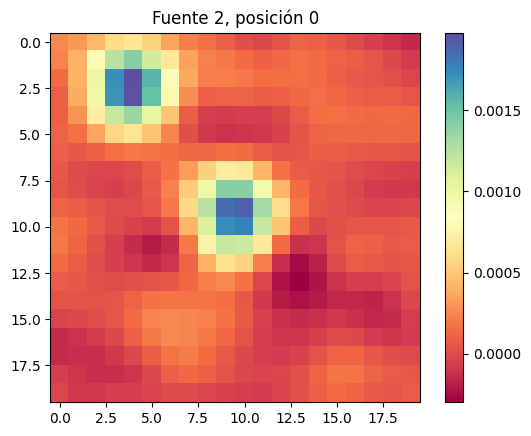

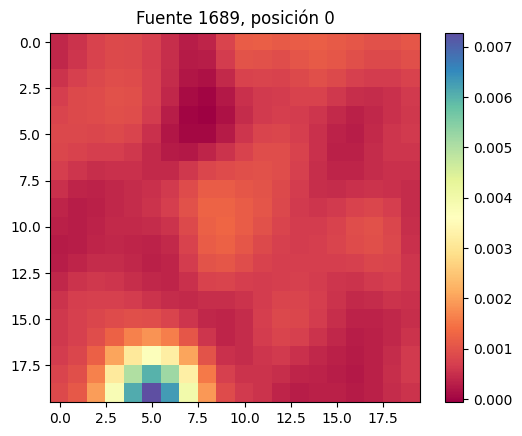

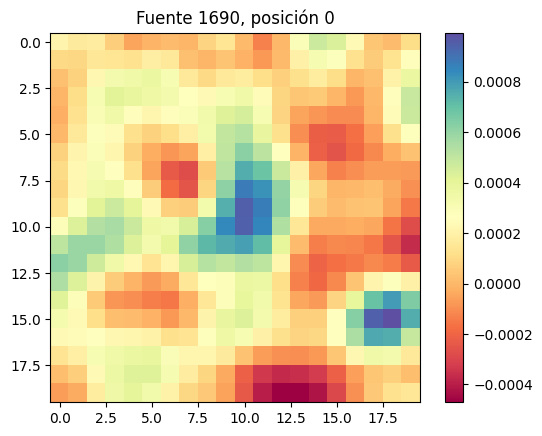

In [96]:
fuentes = [2, 1689, 1690]
for fuente in fuentes:
    x = df.loc[df['source_number'] == fuente, 'x'].values[0]
    y = df.loc[df['source_number'] == fuente, 'y'].values[0]
    ymin, ymax = x - 10, x + 10
    xmin, xmax = y - 10, y + 10

    plt.imshow(hdul[0].data[0][xmin:xmax, ymin:ymax], cmap='Spectral')
    plt.colorbar()
    plt.title(f"Fuente {fuente}, posición 0")
    plt.show()


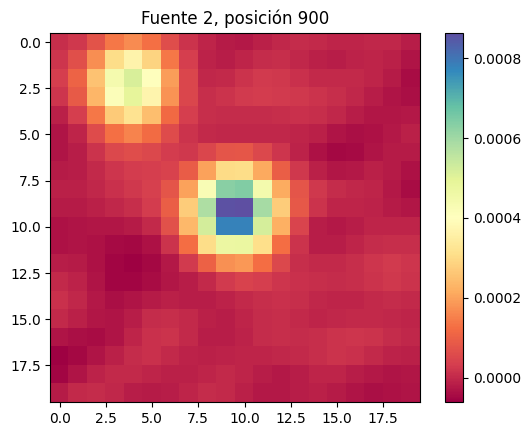

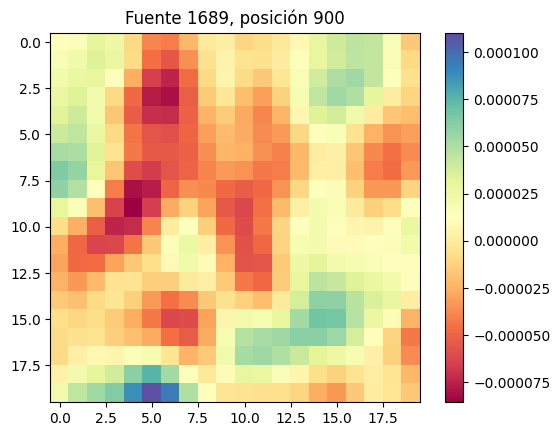

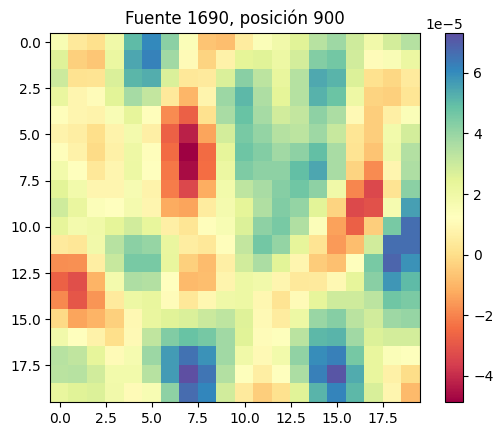

In [97]:
fuentes = [2, 1689, 1690]

for fuente in fuentes:
    x = df.loc[df['source_number'] == fuente, 'x'].values[0]
    y = df.loc[df['source_number'] == fuente, 'y'].values[0]
    ymin, ymax = x - 10, x + 10
    xmin, xmax = y - 10, y + 10

    plt.imshow(hdul[0].data[900][xmin:xmax, ymin:ymax], cmap='Spectral')
    plt.colorbar()
    plt.title(f"Fuente {fuente}, posición 900")
    plt.show()

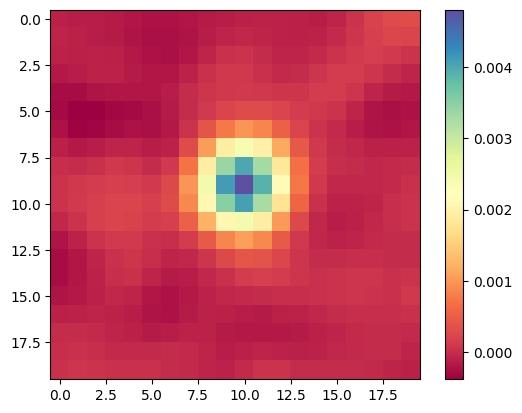

In [33]:
x=10

y=848
	
xmin,xmax=x-10,x+10
ymin,ymax=y-10,y+10
	

plt.imshow(hdul[0].data[0][xmin:xmax,ymin:ymax],cmap='Spectral')
plt.colorbar()

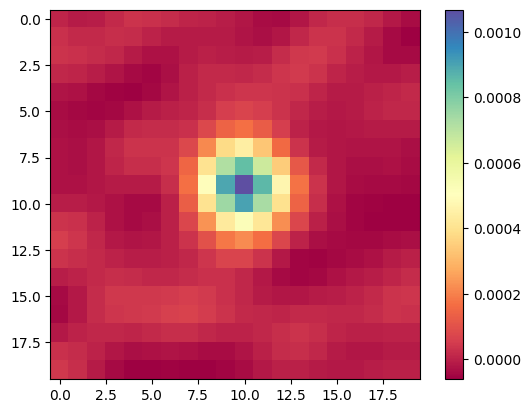

In [32]:
x=61

y=904
	
xmin,xmax=x-10,x+10
ymin,ymax=y-10,y+10
	

plt.imshow(hdul[0].data[900][xmin:xmax,ymin:ymax],cmap='Spectral')
plt.colorbar()

In [31]:
np.max(hdul[0].data[900][xmin:xmax,ymin:ymax])

0.0010677283

In [23]:
final_df_a.to_csv("resultados_catalogo_andres.csv", index=False)

In [24]:
final_df_a_transposed = final_df_a.T
final_df_a_transposed = final_df_a_transposed.iloc[3:]
final_df_a_transposed

,0,1,2,3,4,5,6,7,8,9,...,6602,6603,6604,6605,6606,6607,6608,6609,6610,6611
probability_image_0,0.0,0.035714,0.046875,0.875,0.859375,0.703125,0.0,0.890625,0.546875,0.65625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
probability_image_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.796875,0.593750,0.984375,0.875000,0.843750,0.640625,0.921875,0.453125,0.078125,0.812500
probability_image_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.796875,0.593750,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.812500
probability_image_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.796875,0.640625,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.812500
probability_image_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.796875,0.640625,0.984375,0.875000,0.843750,0.640625,0.921875,0.437500,0.078125,0.796875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
probability_image_896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.687500,0.562500,0.984375,0.859375,0.390625,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.687500,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.687500,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.484375
probability_image_899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.703125,0.562500,0.984375,0.859375,0.375000,0.421875,0.578125,0.000000,0.000000,0.500000
